## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#b57edc; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #b57edc">Libraries</p>

In [1]:
import tensorflow as tf
import os

# GPU 사용 가능 여부 확인
gpu_available = tf.config.list_physical_devices('GPU')

if gpu_available:
    print("GPU를 사용할 수 있습니다.")
    # GPU 정보 출력
    for gpu in gpu_available:
        print("GPU 이름:", gpu.name)
        print("메모리:", tf.config.experimental.get_memory_growth(gpu))
else:
    print("GPU를 사용할 수 없습니다.")
    
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"


GPU를 사용할 수 있습니다.
GPU 이름: /physical_device:GPU:0
메모리: None


In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings("ignore")

from concurrent.futures import ThreadPoolExecutor
from googletrans import Translator

from tqdm import tqdm

import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.impute import SimpleImputer

import time

from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#b57edc; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #b57edc">EDA</p>

In [3]:
listing = pd.read_csv('input_main_listing.csv')

In [4]:
listing.rename(columns = {'address_japanese' : 'address'}, inplace = True)
listing.head()

,price,room_type,accommodates,bedrooms,beds,review_scores_rating,address,shiku,townpart,detailpart
0,1100000.0,Entire home apt,2,1.0,2.0,4.78,墨田区八広2丁目27-16,墨田区,墨田区八広2丁目,27-16
1,720800.0,Private room,1,NaN,1.0,4.98,北区田端新町1丁目26-7,北区,北区田端新町1丁目,26-7
2,2306600.0,Entire home apt,6,2.0,4.0,4.76,渋谷区幡ヶ谷2丁目1-2-1,渋谷区,渋谷区幡ヶ谷2丁目,1-2-1
3,1600000.0,Private room,2,NaN,2.0,4.94,世田谷区代沢2丁目−16、池ノ上フラット,世田谷区,世田谷区代沢2丁目,−16、池ノ上フラット
4,1000000.0,Private room,4,NaN,NaN,4.71,足立区千住宮元町1-2,足立区,NaN,足立区千住宮元町1-2


In [5]:
oshima = pd.read_csv("C:\\Users\\lucky\\Documents\\COLLABORATION\\AirbnbWise\\Dataset_Processing\\jieun\\oshimaEDA.csv")
oshima.head()

,info,date,address,shiku,townpart,detailpart
0,819号室で女性死亡,平成30年5月23日,新宿区歌舞伎町一丁目202,新宿区,歌舞伎町一丁目,202
1,飛び降り自殺,令和3年5月18日,新宿区歌舞伎町一丁目202アパホテル新宿歌舞伎町タワー,新宿区,歌舞伎町一丁目,202アパホテル新宿歌舞伎町タワー
2,告知事項あり※管理会社に直接確認済みハイム大成ビル 403号室賃料¥78000 管理費¥20...,1年以内,新宿区西新宿七丁目1813,新宿区,西新宿七丁目,1813
3,１４Ｆから女性が飛び降り自殺,令和元年9月23日,新宿区西新宿七丁目1713パレステュディオ新宿WEST,新宿区,西新宿七丁目,1713パレステュディオ新宿WEST
4,事故死,2016,新宿区西新宿七丁目2231,新宿区,西新宿七丁目,2231


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:75%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">insideAirbnb(listing.csv)와 oshima.csv에서 주소가 겹치는 데이터 확인</p>

In [6]:
tmp1 = listing[['address', 'shiku','townpart','detailpart']]
tmp2 = oshima[['address', 'shiku','townpart','detailpart']]
display(tmp1.head(), tmp2.head())

,address,shiku,townpart,detailpart
0,墨田区八広2丁目27-16,墨田区,墨田区八広2丁目,27-16
1,北区田端新町1丁目26-7,北区,北区田端新町1丁目,26-7
2,渋谷区幡ヶ谷2丁目1-2-1,渋谷区,渋谷区幡ヶ谷2丁目,1-2-1
3,世田谷区代沢2丁目−16、池ノ上フラット,世田谷区,世田谷区代沢2丁目,−16、池ノ上フラット
4,足立区千住宮元町1-2,足立区,NaN,足立区千住宮元町1-2


,address,shiku,townpart,detailpart
0,新宿区歌舞伎町一丁目202,新宿区,歌舞伎町一丁目,202
1,新宿区歌舞伎町一丁目202アパホテル新宿歌舞伎町タワー,新宿区,歌舞伎町一丁目,202アパホテル新宿歌舞伎町タワー
2,新宿区西新宿七丁目1813,新宿区,西新宿七丁目,1813
3,新宿区西新宿七丁目1713パレステュディオ新宿WEST,新宿区,西新宿七丁目,1713パレステュディオ新宿WEST
4,新宿区西新宿七丁目2231,新宿区,西新宿七丁目,2231


In [7]:
tmp1.shape, tmp2.shape

((11176, 4), (818, 4))

In [8]:
tmp1.dropna(inplace=True)
tmp2.dropna(inplace=True)
tmp1.shape, tmp2.shape

((10466, 4), (767, 4))

In [9]:
# def townpartProcessing(address): #* townpart에 포함된 숫자 제거
#     cleaned_address = re.sub(r'\d', '', address)
#     return cleaned_address

In [10]:
# tmp1['townpart'] = tmp1['townpart'].apply(townpartProcessing)
# tmp2['townpart'] = tmp2['townpart'].apply(townpartProcessing)

In [11]:
#* insideairbnb 데이터 안에 oshima 주소 데이터와 겹치는 곳이 있는지 확인
#* tmp1과 tmp2가 데이터프레임인 경우, address 칼럼을 가져와서 리스트로 변환
#! townpart는 겹치는 데이터 하나도 없음
#! detailpart는 겹치는 데이터 들은 존재하나 상세주소를 제외한 나머지 값이 전혀 달라 활용 할 수가 없음.
shiku_list_tmp1 = tmp1['shiku'].tolist() #* listing data
shiku_list_tmp2 = tmp2['shiku'].tolist() #* oshima data

# 겹치는 주소를 찾기 위해 set의 교집합을 사용
overlapping_addresses = list(set(shiku_list_tmp1) & set(shiku_list_tmp2))

if len(overlapping_addresses) > 0:
    print("oshima와 겹치는 주소가 존재합니다.")
    print("겹치는 주소 목록:")
    print(overlapping_addresses)
else:
    print("oshima와 겹치는 주소가 존재하지 않습니다.")


oshima와 겹치는 주소가 존재합니다.
겹치는 주소 목록:
['目黒区', '小平市', '立川市', '品川区', '港区', '府中市', '昭島市', '練馬区', '東村山市', '世田谷区', '杉並区', '板橋区', '葛飾区', '多摩市', '西東京市', '羽村市', '千代田区', '国分寺市', '小金井市', '北区', '荒川区', '調布市', '八王子市', '墨田区', '町田市', '中野区', '江戸川区', '日野市', '足立区', '三鷹市', '狛江市', '武蔵村山市', '渋谷区', '新宿区', '文京区', '大田区', '中央区', '国立市', '青梅市', '台東区', '豊島区', '江東区', '武蔵野市']


In [12]:
len(overlapping_addresses) #* 43개의 시, 구 겹침

43

In [13]:
shiku_filtered_data = listing[listing['shiku'].isin(overlapping_addresses)] #* 두 데이터프레임에서 겹치는 shiku 데이터만 추출
shiku_filtered_data.reset_index(drop=True, inplace=True)
shiku_filtered_data

,price,room_type,accommodates,bedrooms,beds,review_scores_rating,address,shiku,townpart,detailpart
0,1100000.0,Entire home apt,2,1.0,2.0,4.78,墨田区八広2丁目27-16,墨田区,墨田区八広2丁目,27-16
1,720800.0,Private room,1,NaN,1.0,4.98,北区田端新町1丁目26-7,北区,北区田端新町1丁目,26-7
2,2306600.0,Entire home apt,6,2.0,4.0,4.76,渋谷区幡ヶ谷2丁目1-2-1,渋谷区,渋谷区幡ヶ谷2丁目,1-2-1
3,1600000.0,Private room,2,NaN,2.0,4.94,世田谷区代沢2丁目−16、池ノ上フラット,世田谷区,世田谷区代沢2丁目,−16、池ノ上フラット
4,1000000.0,Private room,4,NaN,NaN,4.71,足立区千住宮元町1-2,足立区,NaN,足立区千住宮元町1-2
...,...,...,...,...,...,...,...,...,...,...
11033,960000.0,Entire home apt,2,1.0,1.0,5.00,新宿区歌舞伎町2丁目4-11,新宿区,新宿区歌舞伎町2丁目,4-11
11034,1200000.0,Entire home apt,4,1.0,3.0,NaN,新宿区北新宿1丁目16番地メゾン・ブランシェ,新宿区,新宿区北新宿1丁目,16番地メゾン・ブランシェ
11035,1600000.0,Entire home apt,3,1.0,2.0,NaN,新宿区北新宿1丁目6-14,新宿区,新宿区北新宿1丁目,6-14
11036,1600000.0,Entire home apt,4,1.0,2.0,NaN,新宿区北新宿1丁目25-21,新宿区,新宿区北新宿1丁目,25-21


In [14]:
shiku_filtered_data.info() #* oshima data와 insideairbnb data 사이의 겹치는 시/구 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11038 entries, 0 to 11037
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 11038 non-null  float64
 1   room_type             11038 non-null  object 
 2   accommodates          11038 non-null  int64  
 3   bedrooms              9134 non-null   float64
 4   beds                  10589 non-null  float64
 5   review_scores_rating  9797 non-null   float64
 6   address               11038 non-null  object 
 7   shiku                 11038 non-null  object 
 8   townpart              10380 non-null  object 
 9   detailpart            11037 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 862.5+ KB


---------------------------------------------------------------------------------------------------

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:75%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">oshima 데이터 일본어 >> 영어 번역 </p>

In [15]:
#* oshima 사건 일본어를 영어로 번역
#* 환경 변수에 Google Cloud Translation API 인증 키를 설정
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:\\Users\\lucky\\Documents\\genie-393805-2ca6729ec32d.json'

# 영어로 번역하는 함수
def translate_japanese_to_english(text):
    try:
        client = translate.Client()
        result = client.translate(text, target_language='en')
        return result['translatedText']
    except:
        # print(f"Error occurred during translation: {e}")
        return None

#* oshima 데이터프레임의 'info' 칼럼을 영어로 번역하여 'translated_info' 리스트에 저장
translated_oshima_info = []
with ThreadPoolExecutor() as executor:
    tqdm.pandas()  # tqdm을 사용하기 위해 pandas에 적용
    translated_oshima_info = list(tqdm(executor.map(translate_japanese_to_english, oshima['info']), total=len(oshima)))

# 'translated_oshima_info'를 새로운 칼럼으로 추가하여 데이터프레임으로 변환
oshima['translated_info'] = translated_oshima_info

100%|██████████| 818/818 [00:00<00:00, 408883.41it/s]


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#1A5D1A; font-size:75%; text-align:left;padding: 0px; border-bottom: 3px solid #1A5D1A">데이터 병합 </p>

In [16]:
#* 일단 info, date 칼럼 삭제
trans_oshima = oshima.drop(columns = ['info', 'date'])

In [17]:
merge_data = pd.concat([listing, trans_oshima])
merge_data.head()

,price,room_type,accommodates,bedrooms,beds,review_scores_rating,address,shiku,townpart,detailpart,translated_info
0,1100000.0,Entire home apt,2.0,1.0,2.0,4.78,墨田区八広2丁目27-16,墨田区,墨田区八広2丁目,27-16,NaN
1,720800.0,Private room,1.0,NaN,1.0,4.98,北区田端新町1丁目26-7,北区,北区田端新町1丁目,26-7,NaN
2,2306600.0,Entire home apt,6.0,2.0,4.0,4.76,渋谷区幡ヶ谷2丁目1-2-1,渋谷区,渋谷区幡ヶ谷2丁目,1-2-1,NaN
3,1600000.0,Private room,2.0,NaN,2.0,4.94,世田谷区代沢2丁目−16、池ノ上フラット,世田谷区,世田谷区代沢2丁目,−16、池ノ上フラット,NaN
4,1000000.0,Private room,4.0,NaN,NaN,4.71,足立区千住宮元町1-2,足立区,NaN,足立区千住宮元町1-2,NaN


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing:2px; color:#b57edc; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #b57edc">모델링 - 평점 예측 시도
</p>

In [18]:
merge_data.head(1)

,price,room_type,accommodates,bedrooms,beds,review_scores_rating,address,shiku,townpart,detailpart,translated_info
0,1100000.0,Entire home apt,2.0,1.0,2.0,4.78,墨田区八広2丁目27-16,墨田区,墨田区八広2丁目,27-16,NaN


In [21]:
#* 라벨 인코딩
le = LabelEncoder()
for idx in merge_data.select_dtypes(include='object').columns:
    merge_data[idx] = le.fit_transform(merge_data[idx])

In [ ]:
# 원핫 인코딩
# TODO : 범주형 칼럼만을 독립 변수로 넣는 경우
# object_columns = merge_data.select_dtypes(include='object')

# # 범주형 칼럼 원-핫 인코딩
# one_hot_encoded = pd.get_dummies(object_columns)

In [ ]:
# TODO : 숫자형 칼럼, 범주형 칼럼 모두 독립 변수로 넣는 경우
# "merge_data"에서 숫자형 칼럼과 범주형 칼럼 분리
# numeric_columns = merge_data.select_dtypes(include='number')
# object_columns = merge_data.select_dtypes(include='object')

# # 범주형 칼럼 원-핫 인코딩
# one_hot_encoded = pd.get_dummies(object_columns)

# 숫자형 칼럼과 원-핫 인코딩된 범주형 칼럼 합치기
# all_data = pd.concat([numeric_columns, one_hot_encoded], axis=1)
# all_data.head()

In [22]:
merge_data['review_scores_rating'] = merge_data['review_scores_rating'].fillna(merge_data['review_scores_rating'].median())

In [23]:
#TODO 머신러닝
#* 독립 변수와 종속 변수로 데이터 분할
X = merge_data.drop(columns = ['review_scores_rating'])
y = merge_data['review_scores_rating']  

#* 결측치를 평균값으로 대체
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

#* 학습용 데이터와 테스트용 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

#* 여러 회귀 모델 정의
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    CatBoostRegressor(verbose=1)
] #* RandomForestRegressor() 너무 오래 걸려서 제외

#* 모델 학습과 평가
y_preds = []  # 모델들의 예측 결과를 저장할 리스트 초기화
for model in models:
    model_name = model.__class__.__name__  # 모델의 이름 가져오기

    #* 모델 학습 시간 측정 시작
    start_time = time.time()

    model.fit(X_train, y_train)  # 모델 학습
    y_pred = model.predict(X_test)  # 모델 예측

    #* 모델 학습 시간 측정 종료
    end_time = time.time()

    #* 모델 학습 시간 계산
    training_time = end_time - start_time

    #* 모델의 성능 평가
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} - Mean Squared Error (MSE):", mse)
    print(f"{model_name} - R-squared (R2):", r2)
    print(f"{model_name} - Training Time: {training_time:.4f} seconds")
    print("=" * 30)

    #* 각 모델의 예측 결과를 y_preds 리스트에 추가
    y_preds.append(y_pred)

#* 가장 성능이 좋은 모델 선택
best_model_idx = np.argmax([r2_score(y_test, y_pred) for y_pred in y_preds])
best_model = models[best_model_idx]

#* 가장 성능이 좋은 모델로 최종 예측 수행
final_y_pred = y_preds[best_model_idx]

#* 최종 모델의 성능 평가
final_mse = mean_squared_error(y_test, final_y_pred)
final_r2 = r2_score(y_test, final_y_pred)

print("=== Final Model Evaluation ===")
print(f"Best Model: {best_model.__class__.__name__}")
print(f"Final Mean Squared Error (MSE): {final_mse}")
print(f"Final R-squared (R2): {final_r2}")

LinearRegression - Mean Squared Error (MSE): 0.10848071490327407
LinearRegression - R-squared (R2): -0.0014322984067587363
LinearRegression - Training Time: 0.0030 seconds
DecisionTreeRegressor - Mean Squared Error (MSE): 0.20157892869617744
DecisionTreeRegressor - R-squared (R2): -0.8608620901381294
DecisionTreeRegressor - Training Time: 0.0900 seconds
Learning rate set to 0.058525
0:	learn: 0.3457081	total: 147ms	remaining: 2m 27s
1:	learn: 0.3452783	total: 149ms	remaining: 1m 14s
2:	learn: 0.3449928	total: 151ms	remaining: 50.1s
3:	learn: 0.3447183	total: 153ms	remaining: 38s
4:	learn: 0.3444064	total: 154ms	remaining: 30.7s
5:	learn: 0.3442046	total: 156ms	remaining: 25.8s
6:	learn: 0.3439551	total: 157ms	remaining: 22.3s
7:	learn: 0.3437357	total: 159ms	remaining: 19.7s
8:	learn: 0.3434819	total: 161ms	remaining: 17.7s
9:	learn: 0.3432761	total: 162ms	remaining: 16.1s
10:	learn: 0.3430623	total: 164ms	remaining: 14.7s
11:	learn: 0.3429068	total: 166ms	remaining: 13.6s
12:	learn: 0

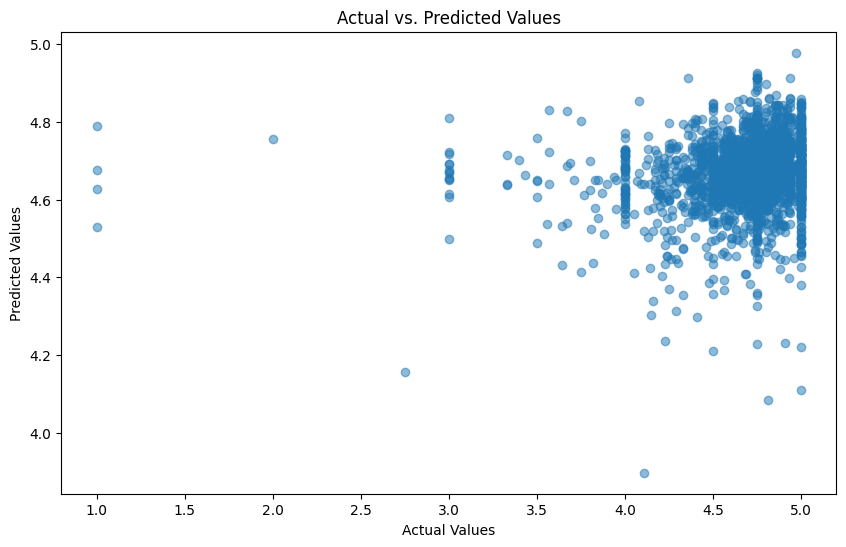

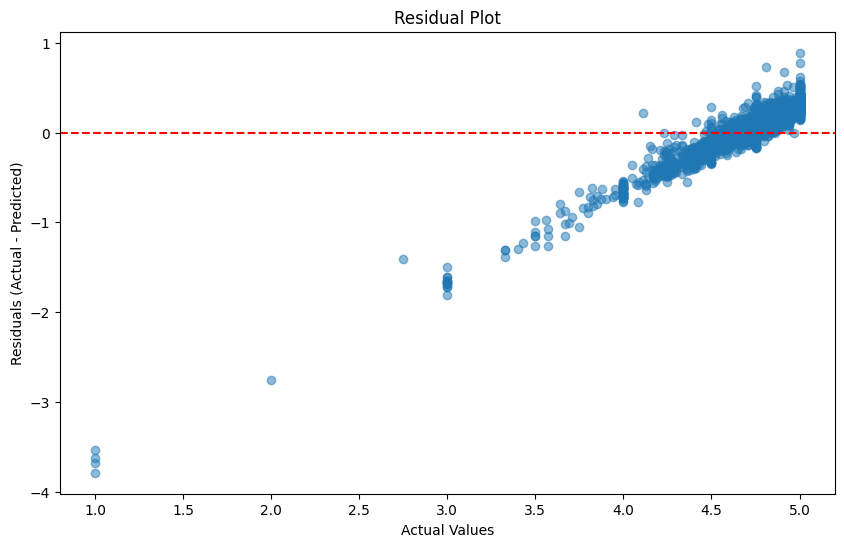

In [24]:
#* 예측 결과와 실제 값 사이의 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

#* 예측 오차(Residual) 플롯 그리기
residuals = y_test - final_y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

In [26]:
final_y_pred #* review_scores_rating 예측 평점

array([4.70612698, 4.71951942, 4.69198091, ..., 4.70000067, 4.69330371,
       4.66960924])

------------------------------------------------------------

R2 스코어는 회귀 모델이 입력 데이터에 얼마나 잘 적합되었는지를 나타내며, 모델이 얼마나 설명력을 가지고 있는지를 측정합니다<br>
R2 스코어는 0과 1 사이의 값을 가지며, 주로 0과 1에 가까울수록 더 좋은 모델을 나타냅니다. R2 스코어가 1이면 모델이 입력 데이터를 완벽하게 설명한다는 의미이며, <br>
0에 가까울수록 모델이 데이터를 설명하지 못하는 경우를 의미합니다. 음수 값이 나오는 경우에는 모델이 입력 데이터보다 적어도 더 나쁜 예측을 한 경우를 의미합니다.<br><br>

CatBoostRegressor의 R-squared 값이 0.008169188040362818로 매우 작지만, 0보다 큰 양수값을 가진다는 것은 데이터를 더 잘 설명하는 경향이 있다는 것을 의미합니다.<br>
하지만 0.008169188040362818은 매우 작기 때문에 모델이 데이터를 제대로 설명하지 못하는 것으로 평가될 수 있습니다.<br>

In [34]:
y_train

8085     4.80
8542     4.75
288      4.92
4969     5.00
10270    4.75
         ... 
788      4.75
5191     4.75
5390     4.75
860      4.74
7270     4.66
Name: review_scores_rating, Length: 9595, dtype: float64

In [35]:
y_test

10415    4.75
1369     4.96
1718     4.80
7520     4.87
360      4.67
         ... 
6270     4.94
5465     4.60
3851     4.64
3070     4.68
6107     4.81
Name: review_scores_rating, Length: 2399, dtype: float64

In [36]:
y_pred

array([4.70612698, 4.71951942, 4.69198091, ..., 4.70000067, 4.69330371,
       4.66960924])